# Instanovo-Glyco Training Data Analysis

In [13]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fix this later, imports should work without this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


from common.utils import get_ipc_files, get_or_create_folder
from common.logger import get_logger_config
from common.constants import (
    BASE_RAW_DATA_DIR,
    BASE_LOGS_DIR,
    BASE_PLOTS_DIR,
    BASE_REPORTS_CSV_DIR,
)

In [14]:
target_data = "PXD035158"
artifacts_sub_dir = (BASE_RAW_DATA_DIR / target_data).as_posix().split("/")[-1]
logs_dir = get_or_create_folder(BASE_LOGS_DIR / artifacts_sub_dir)
plots_dir = get_or_create_folder(BASE_PLOTS_DIR / artifacts_sub_dir)
csv_dir = get_or_create_folder(BASE_REPORTS_CSV_DIR / artifacts_sub_dir)

In [15]:
logger_config = get_logger_config(subdir=artifacts_sub_dir)
logging.config.dictConfig(logger_config)
logger = logging.getLogger(__name__)
plt.rcParams["font.family"]
logging.warning(
    f"Changing matplotlib font from {plt.rcParams['font.family']} to ['monospace']"
)
plt.rcParams["font.family"] = ["monospace"]

2025-04-02 00:41:01,746 - root - WARNING - Changing matplotlib font from ['monospace'] to ['monospace']


In [16]:
logger.info(
    f"Starting with artifacts subdir set to {artifacts_sub_dir}, log_dir set to {logs_dir} and plots_dir set to {plots_dir}"
)

2025-04-02 00:41:01,806 - __main__ - INFO - Starting with artifacts subdir set to PXD035158, log_dir set to /home/hjisaac/AI4Science/instanovo_instadeep/InstanovoGlyco/reports/logs/PXD035158 and plots_dir set to /home/hjisaac/AI4Science/instanovo_instadeep/InstanovoGlyco/reports/plots/PXD035158


In [17]:
def save_figure(filename, save_dir=plots_dir):
    """
    Save the current figure to a file.

    Args:
    filename (str): The name of the file to save the figure to.
    save_dir (str): The directory to save the figure in. Default to "../reports/plots/{artifacts_sub_dir}".
    """

    extensions = [".png", ".jpg", ".jpeg", ".pdf"]
    name, extension = os.path.splitext(filename)
    # We are defaulting the extension to "pdf"
    extension = extension.lower() if extension else ".pdf"

    if extension not in extensions:
        raise ValueError(
            f"Unknown extension {extension} from {filename}. Please choose one from {extensions}"
        )

    save_path = os.path.join(save_dir, f"{name}{extension}")
    plt.savefig(save_path, format=extension[1:], bbox_inches="tight")
    logger.info(f"Saved plot to {save_path}")

In [18]:
# Graphing functions go here
def plot_x_y(
    df, index, x_column, y_column, x_label=None, y_label=None, title=None, filename=None, save=True
):
    """
    Plot x and y arrays for a given line in the DataFrame using vertical lines.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    index (int): The index of the line to plot.
    x_column (str): The name of the x column.
    y_column (str): The name of the y column.
    x_label (str): The label for the x-axis. If None, the x_column name is used.
    y_label (str): The label for the y-axis. If None, the y_column name is used.
    title (str): The title of the plot. If None, a default title is used.
    filename (str): The filename to save the plot. If None, the plot is not saved.
    """
    x_values = df.at[index, x_column]
    y_values = df.at[index, y_column]
    plt.figure(figsize=(10, 6))
    plt.vlines(x_values, ymin=0, ymax=y_values, color="b", alpha=0.7)
    plt.scatter(x_values, y_values, color="b")
    x_label = x_label if x_label else x_column
    y_label = y_label if y_label else y_column
    title = title if title else f"{x_label} vs. {y_label} for index {index}"
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, alpha=0.3)
    if save:
        filename = filename or f"{x_column}_vs_{y_column}_for_index_{index}_xy_plot"
        save_figure(filename)
    plt.show()


def plot_quantitative(
    df, column, xlabel=None, ylabel="Frequency", title=None, filename=None, save=True
):
    """
    Plot histogram and KDE for a quantitative (numeric) column.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column to plot.
    label (str): The label to display on the plot. If None, the column name is used.
    """
    xlabel = xlabel if xlabel else column
    title = title if title else f"Histogram and KDE for {xlabel}"
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.2)
    if save:
        filename = filename or (column + "_histogram")
        save_figure(filename=filename)
    plt.show()


def plot_qualitative(
    df, column, xlabel="Count", ylabel=None, title=None, top_n=20, filename=None, save=True
):
    """
    Plot bar plot for a qualitative (categorical) column.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column to plot.
    label (str): The label to display on the plot. If None, the column name is used.
    top_n (int): The number of top values to display.
    """
    ylabel = ylabel if ylabel else column
    title = (
        title
        if title
        else (
            f"Top {top_n} most frequent values for {ylabel}"
            if top_n
            else ylabel.capitalize()
        )
    )
    top_values = df[column].value_counts().nlargest(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_values.index, x=top_values.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.2)
    if save:
        filename = filename or (column + "_barplot")
        save_figure(filename=filename)
    plt.show()


def plot_x_y_bar(
    df,
    column,
    count_column_name,
    xlabel="Duplicate Count",
    ylabel="Column Combinations",
    title="Duplicate Counts for Different Column Combinations",
    xtick_rotation=45,
    filename=None,
    save=True,
):
    """
    Generates a horizontal bar plot for duplicate counts of column combinations.

    Parameters:
    - results_df: pandas DataFrame containing the data.
    - column_name: str, the column name for the combinations to be plotted.
    - count_name: str, the column name for the duplicate counts to be plotted.
    - xlabel: str, label for the x-axis (default is "Duplicate Count").
    - ylabel: str, label for the y-axis (default is "Column Combinations").
    - title: str, the title of the plot (default is "Duplicate Counts for Different Column Combinations").
    - xtick_rotation: int, angle to rotate x-axis ticks (default is 45).
    """
    plt.figure(
        figsize=(12, max(6, len(df) * 0.3))
    )  # Adjust height dynamically based on the number of rows
    plt.barh(
        df[column],
        df[count_column_name],
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=xtick_rotation)
    plt.tight_layout()  # Prevent overlapping
    plt.grid(True, alpha=0.4)
    plt.gca().invert_yaxis()
    if save:
        filename = filename or (column + "_based_duplicates_count_barplot")
        save_figure(filename=filename)
    plt.show()

In [19]:
# Grab all ipc files of interest but ATTENTION;
# loading all many ipc files will increase the computation time
ipc_files = get_ipc_files(BASE_RAW_DATA_DIR / target_data)

In [20]:
df = pd.concat([pd.read_feather(file) for file in ipc_files], ignore_index=True)
df.head(20)

,index,scan,header,rt,frag_type,collision_energy,precursor_mz,precursor_charge,precursor_intensity,lower_offset,...,modified_peptide,peptide_observed_mz,peptide_calc_mz,delta_mass,expectation,hyperscore,nextscore,probability,auc_intensity,protein
0,7163,controllerType=0 controllerNumber=1 scan=7164,FTMS + c NSI d Full ms2 917.7194@hcd33.00 [120...,1035.362681,HCD,33.0,917.386108,3,9.225750e+06,1.0,...,GGPKN[1762]DTEER,917.3861,917.3799,0.0027,1.933290e-09,38.373,18.158,1.0000,9.664362e+07,sp|Q62443|NPTX1_MOUSE
1,7164,controllerType=0 controllerNumber=1 scan=7165,FTMS + c NSI d Full ms2 785.3360@hcd33.00 [120...,1035.628304,HCD,33.0,785.085449,4,8.758446e+06,1.0,...,KKGDSSSGGGGGSSGGGGSSNVGGGSSGGSGSCSSSSR,785.0855,785.0808,0.0105,0.000000e+00,97.376,13.117,1.0000,7.440552e+07,sp|Q64012|RALY_MOUSE
2,7166,controllerType=0 controllerNumber=1 scan=7167,FTMS + c NSI d Full ms2 1020.4236@hcd33.00 [12...,1036.086781,HCD,33.0,1020.089478,3,4.922692e+06,1.0,...,GGPKN[2070]DTEER,1020.0895,1020.0836,-0.0010,6.758920e-03,31.962,18.467,0.7947,4.561695e+07,sp|Q62443|NPTX1_MOUSE
3,7170,controllerType=0 controllerNumber=1 scan=7171,FTMS + c NSI d Full ms2 973.4209@hcd33.00 [120...,1036.716772,HCD,33.0,973.087219,3,4.103132e+06,1.0,...,KN[2070]QSSELR,973.0872,973.0815,0.0001,7.019999e-03,27.510,17.685,0.9473,3.500579e+07,sp|Q60625|ICAM5_MOUSE
4,7174,controllerType=0 controllerNumber=1 scan=7175,FTMS + c NSI d Full ms2 803.0234@hcd33.00 [120...,1037.280757,HCD,33.0,802.689087,3,1.636536e+06,1.0,...,KN[1559]QSSELR,802.6891,802.6848,0.0080,2.104669e-02,25.936,16.479,0.8262,1.593749e+07,sp|Q60625|ICAM5_MOUSE
5,7179,controllerType=0 controllerNumber=1 scan=7180,FTMS + c NSI d Full ms2 858.6920@hcd33.00 [120...,1037.954999,HCD,33.0,858.357910,3,1.825259e+06,1.0,...,KN[1559]ASNM[147]EYR,858.3579,858.3528,0.0045,2.774861e-03,15.926,10.560,0.9510,1.279363e+07,sp|P97300|NPTN_MOUSE
6,7183,controllerType=0 controllerNumber=1 scan=7184,FTMS + c NSI d Full ms2 1029.0885@hcd33.00 [12...,1038.479256,HCD,33.0,1028.754395,3,1.170969e+07,1.0,...,KN[2070]ASNM[147]EYR,1028.7543,1028.7495,-0.0025,3.434939e-04,19.576,15.023,0.9912,2.989063e+07,sp|P97300|NPTN_MOUSE
7,7246,controllerType=0 controllerNumber=1 scan=7247,FTMS + c NSI d Full ms2 1047.1151@hcd33.00 [12...,1047.599808,HCD,33.0,1046.446899,3,1.696184e+05,1.0,...,KKGDSSSGGGGGSSGGGGSSNVGGGSSGGSGSCSSSSR,1046.4469,1046.4387,-0.0002,4.397947e-02,10.927,0.000,0.8031,3.325209e+05,sp|Q64012|RALY_MOUSE
8,7376,controllerType=0 controllerNumber=1 scan=7377,FTMS + c NSI d Full ms2 785.5887@hcd33.00 [120...,1066.347446,HCD,33.0,785.086670,4,7.032864e+04,1.0,...,KKGDSSSGGGGGSSGGGGSSNVGGGSSGGSGSCSSSSR,785.0867,785.0808,0.0087,6.866731e-03,14.153,0.000,0.9397,0.000000e+00,sp|Q64012|RALY_MOUSE
9,8725,controllerType=0 controllerNumber=1 scan=8726,FTMS + c NSI d Full ms2 881.0269@hcd33.00 [120...,1261.293466,HCD,33.0,880.692810,3,3.934957e+04,1.0,...,SVAHN[1493]M[147]TM[147]PNK,880.6928,880.6855,0.0029,4.668943e-02,12.557,7.683,0.8265,2.468170e+06,sp|P62812|GBRA1_MOUSE


## Columns description

| **Field**               | **Description**                                                                                   |
|--------------------------|---------------------------------------------------------------------------------------------------|
| `index`                 | A unique identifier for each entry in the dataset.                                                |
| `scan`                  | The scan number corresponding to the acquisition of the mass spectrum.                            |
| `header`                | Additional metadata about the scan, such as file source or retention time.                        |
| `rt` (Retention Time)   | The time it takes for the peptide to travel through the chromatographic column.                   |
| `frag_type`             | The type of fragmentation used (e.g., CID, HCD, ETD).                                             |
| `collision_energy`      | The energy applied to fragment precursor ions.                                                    |
| `precursor_mz`          | The mass-to-charge ratio (\(m/z\)) of the precursor ion before fragmentation.                     |
| `precursor_charge`      | The charge state of the precursor ion (e.g., +2, +3).                                             |
| `precursor_intensity`   | The intensity of the precursor ion signal, reflecting its abundance.                              |
| `lower_offset`          | The lower bound of the \(m/z\) window for isolating the precursor ion.                            |
| `upper_offset`          | The upper bound of the \(m/z\) window for isolating the precursor ion.                            |
| `isolation_target`      | The target \(m/z\) value for isolating the precursor ion.                                         |
| `mz`                   | The mass-to-charge ratio (\(m/z\)) of ions detected in the spectrum.                              |
| `intensity`             | The intensity of ions detected in the spectrum, reflecting their abundance.                       |
| `scale_factor`          | A scaling factor applied to intensities for normalization.                                        |
| `peptide`               | The sequence of the identified peptide, without modifications.                                    |
| `modified_peptide`      | The sequence of the peptide with post-translational modifications (e.g., glycosylation).          |
| `peptide_observed_mz`   | The observed \(m/z\) of the peptide in the spectrum.                                              |
| `peptide_calc_mz`       | The theoretical \(m/z\) of the peptide based on its sequence and modifications.                   |
| `delta_mass`            | The difference between observed and calculated mass, indicating potential modifications or errors. |
| `retention`             | The retention time of the peptide, used for identification confirmation.                          |
| `expectation`           | A statistical value (e.g., E-value) indicating the reliability of peptide identification.          |
| `hyperscore`            | A confidence score for peptide identification (e.g., from Mascot or Sequest).                     |
| `nextscore`             | An additional confidence score for peptide identification.                                        |
| `probability`           | The probability that the peptide identification is correct.                                       |
| `auc_intensity`         | The area under the curve (AUC) of the signal intensity, used for quantification.                  |
| `protein`               | The protein to which the peptide belongs, identified from a database.                             |

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312275 entries, 0 to 312274
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                312275 non-null  int64  
 1   scan                 312275 non-null  object 
 2   header               312275 non-null  object 
 3   rt                   312275 non-null  float64
 4   frag_type            312275 non-null  object 
 5   collision_energy     312275 non-null  float64
 6   precursor_mz         312275 non-null  float64
 7   precursor_charge     312275 non-null  int64  
 8   precursor_intensity  312275 non-null  float64
 9   lower_offset         312275 non-null  float64
 10  upper_offset         312275 non-null  float64
 11  isolation_target     263885 non-null  float64
 12  mz                   312275 non-null  object 
 13  intensity            312275 non-null  object 
 14  scale_factor         312275 non-null  float32
 15  peptide          

In [22]:
df[["mz"]].iloc[0].mz

array([ 120.60786438,  121.02819061,  122.0606308 ,  122.49898529,
        122.50406647,  122.61053467,  122.61548615,  124.03944397,
        125.65531158,  126.0552063 ,  126.05969238,  126.06336212,
        126.06600189,  126.07221985,  127.03414154,  127.03928375,
        127.05270386,  127.05850983,  128.04240417,  128.05978394,
        129.05435181,  129.10235596,  130.09764099,  131.72505188,
        131.83676147,  131.84190369,  137.59197998,  137.59675598,
        138.0552063 ,  138.06027222,  138.0647583 ,  138.06758118,
        138.07084656,  138.5158844 ,  139.05288696,  139.05853271,
        140.05912781,  140.07081604,  144.06578064,  144.07087708,
        145.04966736,  145.06265259,  145.06933594,  145.17408752,
        145.18125916,  145.28590393,  145.29193115,  145.39787292,
        150.0552063 ,  156.0657959 ,  158.0927887 ,  161.2908783 ,
        161.40228271,  161.5144043 ,  161.62574768,  162.07629395,
        163.06048584,  167.03392029,  167.62640381,  167.73802

In [23]:
highly_relevant_columns = [
    "peptide",
    "modified_peptide",
    "precursor_mz",
    "precursor_charge",
    "mz",
    "intensity",
    "rt",
    "delta_mass",
    "protein",
]

moderatly_relevant_columns = [
    "scan",
    "header",
    "frag_type",
    "collision_energy",
    "precursor_intensity",
    "peptide_observed_mz",
    "peptide_calc_mz",
    "auc_intensity",
]

less_relevant_columns = [
    "index",
    "lower_offset",
    "upper_offset",
    "isolation_target",
    "scale_factor",
    "expectation",
    "hyperscore",
    "nextscore",
]

### Recap statistics for relevant and less relevant columns

In [27]:
df_described = df[highly_relevant_columns].describe()
df_described.to_csv(csv_dir / "highly_relevant_columns_described_df.csv", index=False)
df_described

,precursor_mz,precursor_charge,rt,delta_mass
count,312275.000000,312275.000000,312275.000000,312275.000000
mean,1117.679474,2.921531,8427.788261,0.244578
std,239.807130,0.741625,3310.433069,0.514800
min,699.680603,2.000000,6.927878,-1.155900
25%,934.766388,2.000000,5892.105705,-0.000600
50%,1114.715210,3.000000,8520.580367,0.001600
75%,1268.630981,3.000000,11022.939248,0.012900
max,1998.882324,7.000000,14402.506499,3.191600


In [28]:
df_described = df[moderatly_relevant_columns].describe()
df_described.to_csv(
    csv_dir / "moderatly_relevant_columns_described_df.csv", index=False
)
df_described

,collision_energy,precursor_intensity,peptide_observed_mz,peptide_calc_mz,auc_intensity
count,312275.000000,3.122750e+05,312275.000000,312275.000000,3.122750e+05
mean,28.557867,1.026321e+07,1117.660569,1117.575224,2.461839e+08
std,6.469953,7.873203e+07,239.796809,239.775318,2.592035e+09
min,15.000000,0.000000e+00,699.680600,699.677500,0.000000e+00
25%,20.000000,1.551230e+06,934.764650,934.755300,0.000000e+00
50%,33.000000,3.112122e+06,1114.715000,1114.607300,8.106038e+06
75%,33.000000,6.636691e+06,1268.573900,1268.566100,6.281992e+07
max,33.000000,7.483633e+09,1998.547800,1997.921400,2.009568e+11


In [29]:
df_described = df[less_relevant_columns].describe()
df_described.to_csv(csv_dir / "less_relevant_columns_described_df.csv", index=False)
df_described

,index,lower_offset,upper_offset,isolation_target,scale_factor,expectation,hyperscore,nextscore
count,312275.000000,312275.000000,312275.000000,263885.000000,3.122750e+05,3.122750e+05,312275.000000,312275.000000
mean,57147.422115,0.940983,0.940983,1139.965893,9.946876e+05,4.589059e-03,42.537462,13.618858
std,22714.123346,0.186757,0.186757,235.068990,6.233804e+06,4.418408e-02,20.013936,8.389021
min,46.000000,0.350000,0.350000,700.014709,8.564084e+03,0.000000e+00,4.422000,0.000000
25%,39776.000000,1.000000,1.000000,962.007446,1.389481e+05,0.000000e+00,27.417000,10.159000
50%,57704.000000,1.000000,1.000000,1136.833130,3.181235e+05,8.010000e-12,39.417000,12.187000
75%,75073.000000,1.000000,1.000000,1285.043457,6.883350e+05,3.915054e-06,53.574500,14.775000
max,101410.000000,1.000000,1.000000,1999.223877,1.148524e+09,2.140142e+00,219.745000,106.734000


### Duplicate investigation

2025-04-02 00:42:31,323 - __main__ - INFO - Combination size: 1, duplicate count: 303858
2025-04-02 00:42:31,436 - __main__ - INFO - Combination size: 1, duplicate count: 298498
2025-04-02 00:42:31,482 - __main__ - INFO - Combination size: 1, duplicate count: 164009
2025-04-02 00:42:31,503 - __main__ - INFO - Combination size: 1, duplicate count: 312269
2025-04-02 00:43:02,383 - __main__ - INFO - Combination size: 1, duplicate count: 0
2025-04-02 00:43:29,492 - __main__ - INFO - Combination size: 1, duplicate count: 0
2025-04-02 00:43:29,658 - __main__ - INFO - Combination size: 2, duplicate count: 294187
2025-04-02 00:43:29,743 - __main__ - INFO - Combination size: 2, duplicate count: 160952
2025-04-02 00:43:29,806 - __main__ - INFO - Combination size: 2, duplicate count: 301250
2025-04-02 00:43:57,032 - __main__ - INFO - Combination size: 2, duplicate count: 0
2025-04-02 00:44:22,339 - __main__ - INFO - Combination size: 2, duplicate count: 0
2025-04-02 00:44:22,434 - __main__ - INFO

                                              columns  duplicate_count
0   peptide,                 ,             ,      ...           303858
1          , modified_peptide,             ,      ...           298498
2          ,                 , precursor_mz,      ...           164009
3          ,                 ,             , precu...           312269
4          ,                 ,             ,      ...                0
..                                                ...              ...
58  peptide, modified_peptide, precursor_mz,      ...                0
59  peptide, modified_peptide,             , precu...                0
60  peptide,                 , precursor_mz, precu...                0
61         , modified_peptide, precursor_mz, precu...                0
62  peptide, modified_peptide, precursor_mz, precu...                0

[63 rows x 2 columns]


2025-04-02 01:15:57,231 - __main__ - INFO - Saved plot to /home/hjisaac/AI4Science/instanovo_instadeep/InstanovoGlyco/reports/plots/PXD035158/columns_based_duplicates_count_barplot.pdf


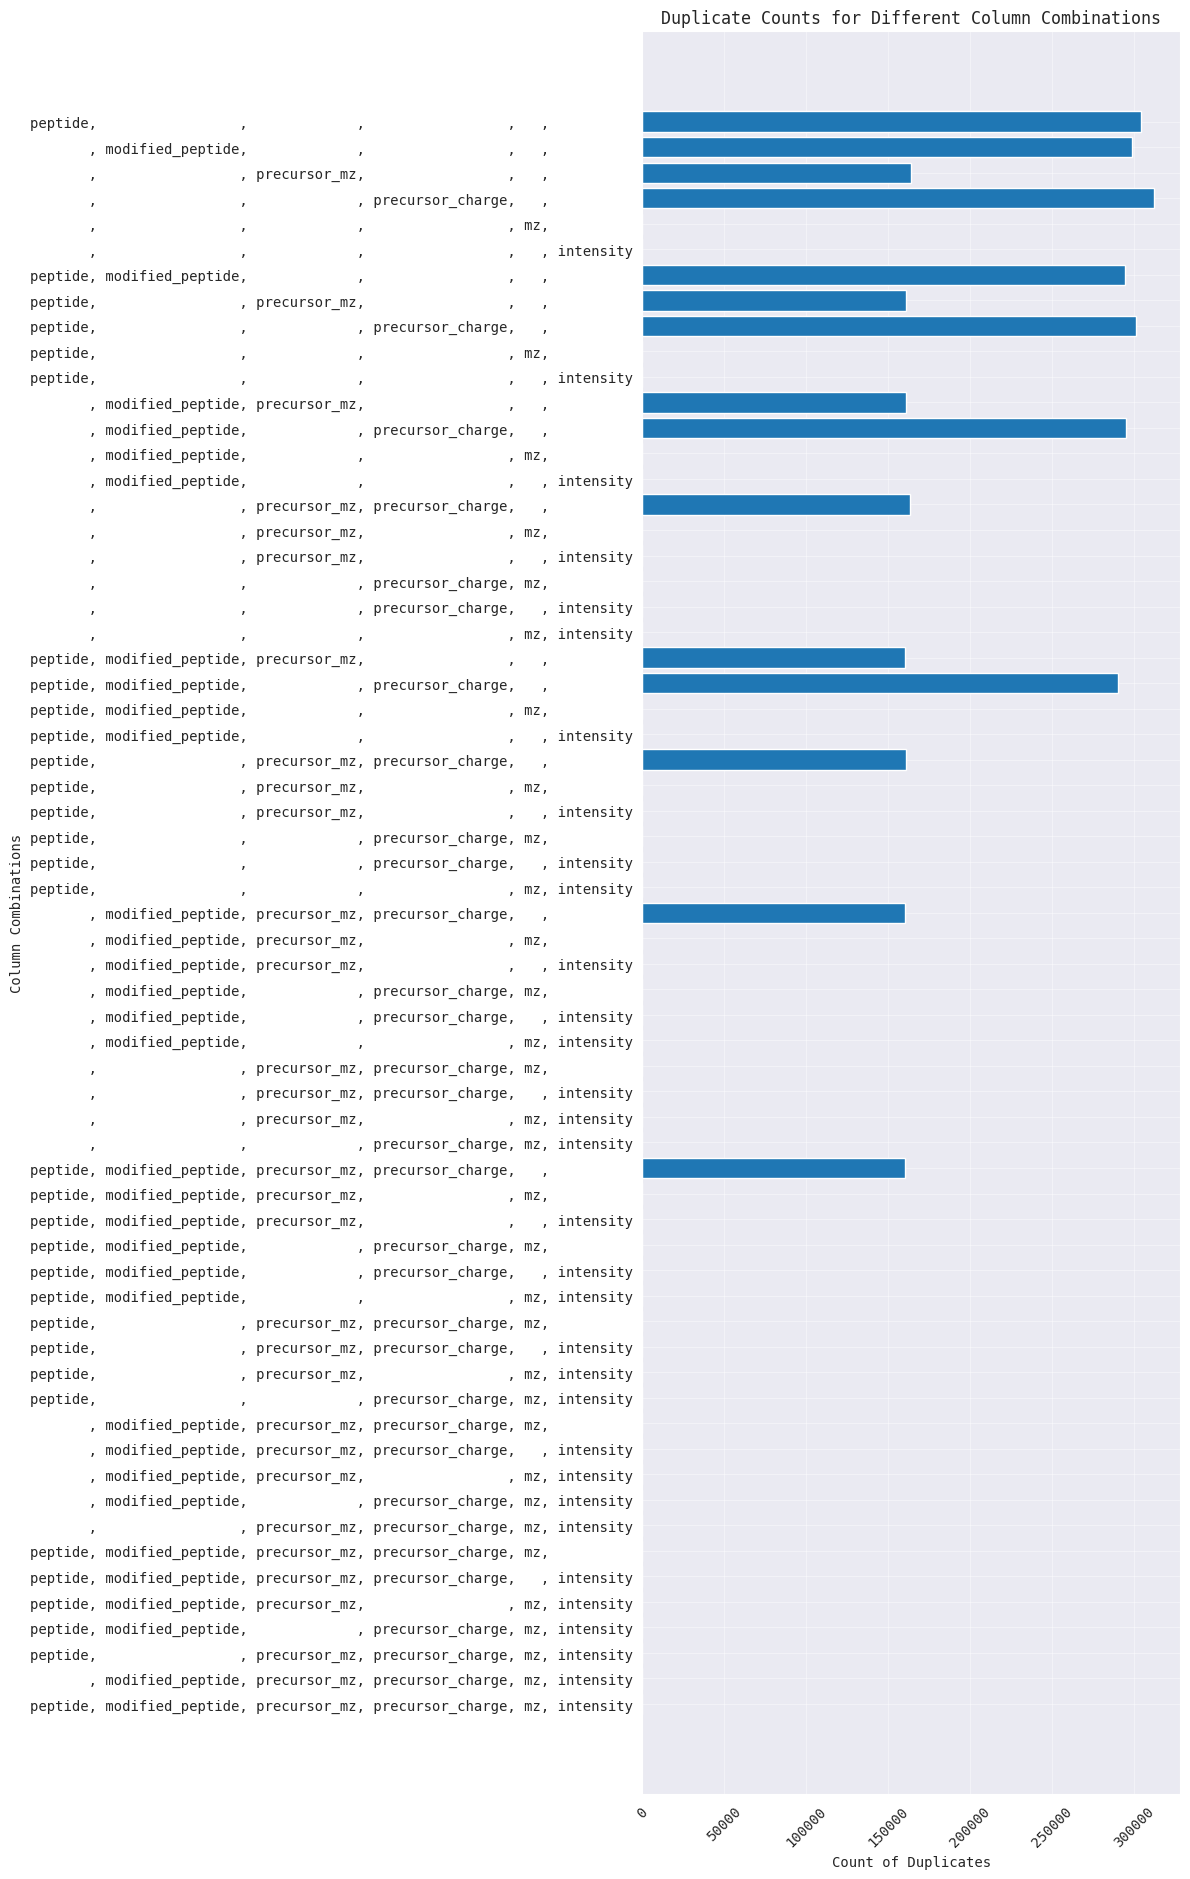

In [25]:
# Investigate duplicates
logger.info("Start replacing list or np.ndarray with tuples")

for column in ("mz", "intensity"):

    # Convert array-like values in the specified columns to tuples. Using
    # another new column will make use of a lot of memory. So, let's just
    # overwrite the values in the specified column.
    df[column] = df[column].apply(
        lambda x: tuple(x) if isinstance(x, (np.ndarray, list)) else x
    )
logger.info("Finish replacing list or np.ndarray with tuples")
# List of columns to consider
columns_to_check = [
    "peptide",
    "modified_peptide",
    "precursor_mz",
    "precursor_charge",
    "mz",
    "intensity",
    # "delta_mass",
    # "protein",
]


# Function to generate aligned labels
def format_label(columns_in_combination):
    formatted = []
    for col in columns_to_check:
        if col in columns_in_combination:
            formatted.append(col.ljust(len(col)))  # Keep column name
        else:
            formatted.append(" " * len(col))  # Add spaces of equal width
    return ", ".join(formatted)  # Use separator for clarity


# Initialize a list to store results
results = []

# Iterate through each combination of column sizes (1-permutation, 2-permutation, etc.)
for size in range(1, len(columns_to_check) + 1):
    for comb in itertools.combinations(columns_to_check, size):
        # Count duplicates for the current combination of columns
        duplicate_count = df[list(comb)].duplicated().sum()
        # FIXME: Here .debug should be used
        logger.info(f"Combination size: {size}, duplicate count: {duplicate_count}")
        # Store the result as a tuple of (combination, duplicate_count)
        results.append(
            {"columns": format_label(comb), "duplicate_count": duplicate_count}
        )

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame with duplicate counts
print(results_df)

# Plotting the results
plot_x_y_bar(
    results_df,
    "columns",
    "duplicate_count",
    xlabel="Count of duplicates",
    ylabel="Column Combinations",
    title="Duplicate counts for different column combinations",
    xtick_rotation=45,
)

In [39]:
# Access the mz and intensity of the most abundant peptide and modification
most_abundant_peptide = df["peptide"].value_counts().idxmax()
print("Most frequent peptide:", most_abundant_peptide)
most_abundant_rows = df.loc[df["peptide"] == most_abundant_peptide][highly_relevant_columns]
most_abundant_rows[:50].to_csv(csv_dir / "most_abundant_peptide_50_first_rows.csv", index=False)
most_abundant_rows.head()


Most frequent peptide: MVSHHNLTTGATLINEQWLLTTAK


,peptide,modified_peptide,precursor_mz,precursor_charge,mz,intensity,rt,delta_mass,protein
53655,MVSHHNLTTGATLINEQWLLTTAK,M[147]VSHHN[2028]LTTGATLINEQWLLTTAK,1153.027222,4,"(120.08075714111328, 121.02824401855469, 123.0...","(0.0024984183, 0.05103352, 0.0027323694, 0.002...",7509.337491,0.0074,sp|P00738|HPT_HUMAN
53656,MVSHHNLTTGATLINEQWLLTTAK,M[147]VSHHN[2028]LTTGATLINEQWLLTTAK,1153.027222,4,"(121.02823638916016, 126.05489349365234, 133.8...","(0.008213762, 0.016716018, 0.002278533, 0.0018...",7509.643113,0.0074,sp|P00738|HPT_HUMAN
53658,MVSHHNLTTGATLINEQWLLTTAK,M[147]VSHHN[2028]LTTGATLINEQWLLTTAK,1537.033813,3,"(120.66404724121094, 121.02816772460938, 122.3...","(0.0037827296, 0.020745292, 0.0038591998, 0.00...",7511.157332,0.0172,sp|P00738|HPT_HUMAN
53913,MVSHHNLTTGATLINEQWLLTTAK,M[147]VSHHN[2028]LTTGATLINEQWLLTTAK,1537.034790,3,"(121.02836608886719, 126.04975128173828, 126.0...","(0.025202964, 0.008873756, 0.13966677, 0.00871...",7649.287397,0.0157,sp|P00738|HPT_HUMAN
53917,MVSHHNLTTGATLINEQWLLTTAK,M[147]VSHHN[1737]LTTGATLINEQWLLTTAK,1080.253296,4,"(120.08032989501953, 121.02825927734375, 121.2...","(0.0024967948, 0.013139191, 0.0016663962, 0.15...",7650.883880,0.0004,sp|P00738|HPT_HUMAN


In [ ]:
plot_qualitative(df, "modified_peptide", "Modified peptides")
plot_qualitative(df, "peptide", "Peptide")
plot_qualitative(df, "protein", "Proteins")

In [ ]:
plot_quantitative(df, "precursor_mz", xlabel="Precursor m/z")
plot_quantitative(df, "precursor_charge", xlabel="Precursor charge")
plot_quantitative(df, "delta_mass", xlabel="Delta mass")

2025-04-02 02:27:44,385 - __main__ - INFO - Saved plot to /home/hjisaac/AI4Science/instanovo_instadeep/InstanovoGlyco/reports/plots/PXD035158/mz_vs_intensity_for_index_0_xy_plot.pdf


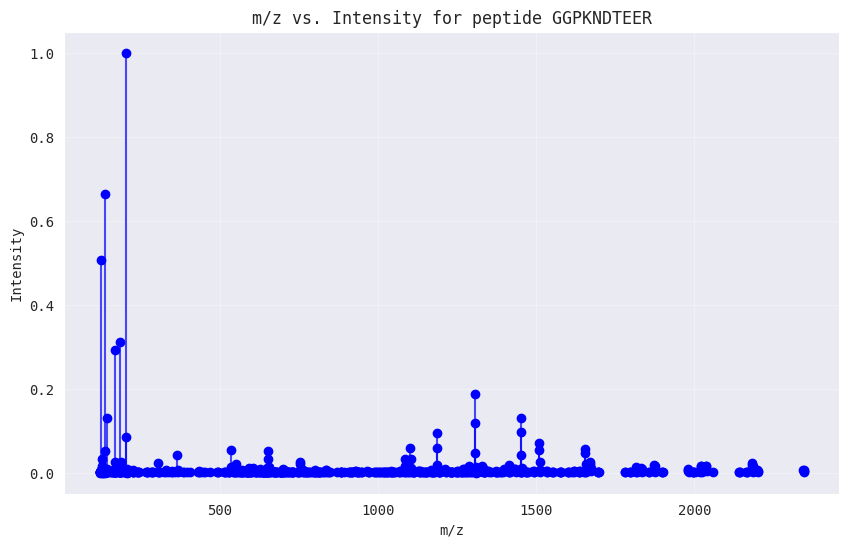

In [40]:
peptide_index = 0
plot_x_y(
    df,
    peptide_index,
    "mz",
    "intensity",
    "m/z",
    "Intensity",
    title=f'm/z vs. Intensity for peptide {df.iloc[peptide_index]["peptide"]}',
)


KeyboardInterrupt



## PTMs identification

The scripts `scripts/identify_ptms` helps in identifying ptms.